# Setup

In [ ]:
# !pip install transformers
!pip install datasets
!pip install sentence_transformers
!pip install umap-learn
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, load_dataset
from transformers import pipeline, BertTokenizer, BertModel, AutoTokenizer, AutoModelForCausalLM
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, silhouette_score, davies_bouldin_score
import umap.umap_ as umap
from sentence_transformers import SentenceTransformer
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import gc
from google.colab import files

# Download stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


# Model Load: facebook/bart-large-mnli

In [ ]:
# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli",
                      batch_size=200,
                      device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

# Help functions

In [ ]:
# Preprocess function to clean text
def preprocess_text(text):
    """
    Preprocesses text by removing URLs, mentions, punctuation, converting to lowercase,
    and removes stopwords.
    """
    # Remove URLs, mentions, punctuation, and lowercase the text
    text = re.sub(r"http\S+|@\S+", "", text)  # Remove URLs and mentions
    text = re.sub(r"[^\w\s]", "", text)       # Remove punctuation
    text = text.strip().lower()               # Convert to lowercase

    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Rejoin the cleaned words
    cleaned_text = " ".join(words)
    return cleaned_text


# Function to drop text based on length constraints
def text_drop(df, text, lower_bound=None, upper_bound=None):
    """
    Drops rows where text length is below lower_bound or above upper_bound.

    Parameters:
    df (pd.DataFrame): The dataframe to process.
    text (str): The column containing text data.
    lower_bound (int): Minimum acceptable text length (word count).
    upper_bound (int): Maximum acceptable text length (word count).

    Returns:
    pd.DataFrame: DataFrame with filtered rows based on text length.
    """
    # Preprocess the text
    df['processed_text'] = df[text].apply(preprocess_text)

    # Calculate text lengths
    df['text_length'] = df['processed_text'].apply(lambda x: len(x.split()))

    # Filter the dataframe based on the calculated bounds
    if lower_bound is None or upper_bound is None:
        # Calculate lower and upper bounds using IQR if not provided
        Q1 = df['text_length'].quantile(0.25)
        Q3 = df['text_length'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1  # Minimum meaningful length based on Q1
        upper_bound = Q3 + 1.5 * IQR  # Maximum meaningful length (outliers above this threshold are removed)

    # Drop rows where text length is outside the bounds
    df_filtered = df[(df['text_length'] >= lower_bound) & (df['text_length'] <= upper_bound)]
    return df_filtered

In [ ]:
topics = ["family", "work", "food", "sleep", "friends", "health", "recreation", "god", "love", "school", "exercise"]

def classify_topics(batch):
    results = classifier(batch['processed_text'], candidate_labels=topics, multi_label=False)
    labels = []
    confidences = []

    for result in results:
        # Initialize default label to "no topic"
        predicted_label = "no topic"
        max_confidence = 0

        for label, score in zip(result['labels'], result['scores']):
            # Check if the score is above the threshold for the current label
            threshold = class_thresholds.get(label, 0.9)  # Default to 0.9 if not set for the label
            if score > threshold:
                # Track the label with the highest score above the threshold
                if score > max_confidence:
                    predicted_label = label
                    max_confidence = score

        labels.append(predicted_label)
        confidences.append(max_confidence)

    return {"predicted_label": labels, "confidence": confidences}

# Jounral Entries

In [ ]:
path = 'https://raw.githubusercontent.com/xaliceli/lemotif/refs/heads/master/assets/data/lemotif-data-cleaned-flat.csv'
journal_df = pd.read_csv(path)
journal_df.head()

,Answer,Answer.f1.afraid.raw,Answer.f1.angry.raw,Answer.f1.anxious.raw,Answer.f1.ashamed.raw,Answer.f1.awkward.raw,Answer.f1.bored.raw,Answer.f1.calm.raw,Answer.f1.confused.raw,Answer.f1.disgusted.raw,...,Answer.t1.family.raw,Answer.t1.food.raw,Answer.t1.friends.raw,Answer.t1.god.raw,Answer.t1.health.raw,Answer.t1.love.raw,Answer.t1.recreation.raw,Answer.t1.school.raw,Answer.t1.sleep.raw,Answer.t1.work.raw
0,"My family was the most salient part of my day,...",False,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,Yoga keeps me focused. I am able to take some ...,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"Yesterday, my family and I played a bunch of b...",False,False,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
3,"Yesterday, I visited my parents and had dinner...",False,False,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
4,"Yesterday, I really felt the importance of my ...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


extract exact topic

In [ ]:
from os import rename
topic_columns = [col for col in journal_df.columns if 't1.' in col]
def extract_topics(row):
    return [col.split(".")[-2] for col in topic_columns if row[col] == True]

journal_df['true_topic'] = journal_df.apply(lambda row: ", ".join(extract_topics(row)) if len(extract_topics(row)) > 0 else np.NaN, axis=1)
journal_df = journal_df.rename(columns={"Answer": "text"})
journal_df.head()

,text,Answer.f1.afraid.raw,Answer.f1.angry.raw,Answer.f1.anxious.raw,Answer.f1.ashamed.raw,Answer.f1.awkward.raw,Answer.f1.bored.raw,Answer.f1.calm.raw,Answer.f1.confused.raw,Answer.f1.disgusted.raw,...,Answer.t1.food.raw,Answer.t1.friends.raw,Answer.t1.god.raw,Answer.t1.health.raw,Answer.t1.love.raw,Answer.t1.recreation.raw,Answer.t1.school.raw,Answer.t1.sleep.raw,Answer.t1.work.raw,true_topic
0,"My family was the most salient part of my day,...",False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,family
1,Yoga keeps me focused. I am able to take some ...,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,exercise
2,"Yesterday, my family and I played a bunch of b...",False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,family
3,"Yesterday, I visited my parents and had dinner...",False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,family
4,"Yesterday, I really felt the importance of my ...",False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,health


In [ ]:
journal_df.dropna(subset=['true_topic'], inplace=True)
print(journal_df.shape)
journal_df.true_topic.value_counts()

(1471, 33)

## Preprocess

In [ ]:
# Apply text dropping (you can specify lower and upper bounds or let it calculate based on IQR)
journal_cleaned = text_drop(journal_df, "text")
print(journal_cleaned.shape)
# Convert to Hugging Face Dataset for GPU batch processing
journal_cleaned = Dataset.from_pandas(journal_cleaned)

(1080, 33)


In [ ]:
# Apply classification in batches and add results directly to the dataset
journal_labeled = journal_cleaned.map(classify_topics, batched=True, batch_size=200)

# Convert back to DataFrame for analysis and save results
journal_labeled = journal_labeled.to_pandas()
journal_labeled.to_csv('journal_labeled_preprocess.csv', index=False)
print("Classification complete. Results saved to 'journal_labeled_preprocess.csv'.")
files.download('journal_labeled_preprocess.csv')

Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

Classification complete. Results saved to 'journal_labeled_preprocess.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluation

Classification Report:
              precision    recall  f1-score   support

      family       0.92      0.41      0.57       210
        work       0.92      0.46      0.62       181
        food       0.98      0.37      0.53       134
       sleep       0.99      0.71      0.82        95
     friends       0.92      0.66      0.77        68
      health       0.91      0.28      0.43        72
  recreation       0.83      0.16      0.27        63
         god       0.95      0.43      0.59        47
        love       0.58      0.15      0.23        48
      school       0.21      0.31      0.25        16
    exercise       1.00      0.12      0.22       146
    no topic       0.00      0.00      0.00         0

    accuracy                           0.38      1080
   macro avg       0.77      0.34      0.44      1080
weighted avg       0.91      0.38      0.51      1080



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


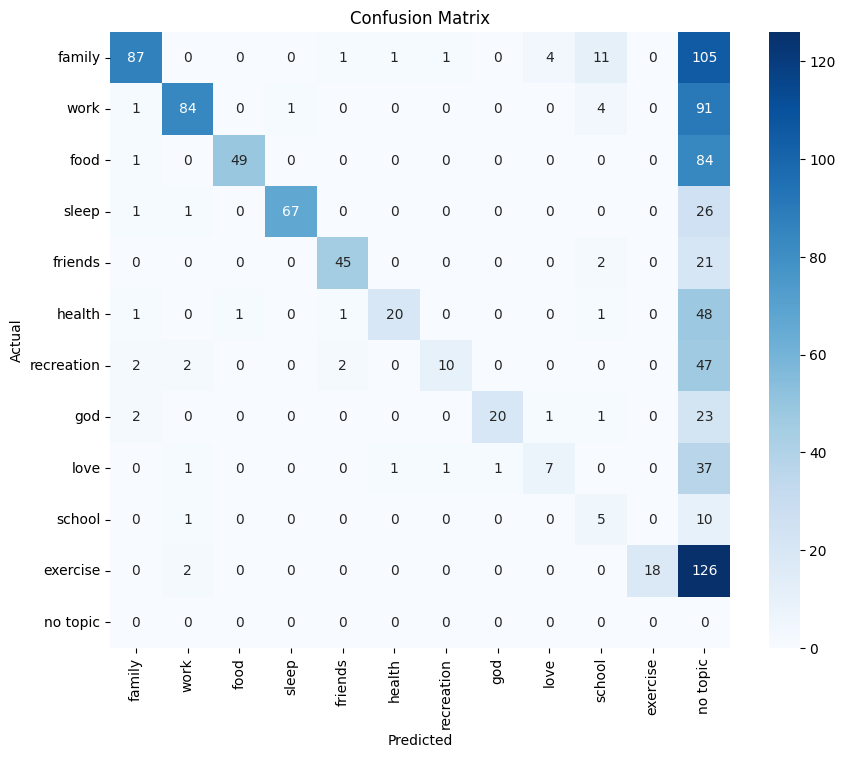

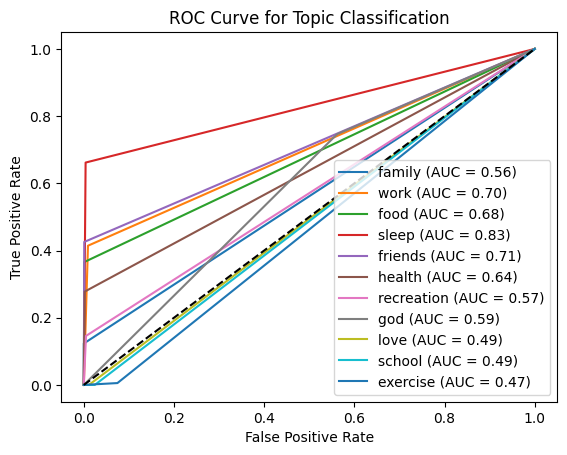

Average AUC: 0.612367317270677
AUC for each topic {'family': 0.5616438356164384, 'work': 0.7025451559934319, 'food': 0.6823072796693068, 'sleep': 0.8289060683561962, 'friends': 0.7122819303412906, 'health': 0.6378968253968254, 'recreation': 0.5704941860465116, 'god': 0.5922882427307206, 'love': 0.4943609022556391, 'school': 0.4878172588832487, 'exercise': 0.4654988046878361}


In [ ]:
journal_preprocessed = pd.read_csv('journal_labeled_preprocess.csv')
topics = ["family", "work", "food", "sleep", "friends", "health", "recreation", "god", "love", "school", "exercise"]

# Map actual and predicted labels into integers (for multi-class evaluation)
topic_mapping = {topic: idx for idx, topic in enumerate(topics + ["no topic"])}

# Convert actual and predicted labels to numeric arrays
y_true = journal_preprocessed['true_topic'].map(topic_mapping).values
y_pred = journal_preprocessed['predicted_label'].map(topic_mapping).values

# Precision, Recall, and F1-Score per class
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=topics + ["no topic"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=topics + ["no topic"], yticklabels=topics + ["no topic"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC Curve (if multi-label=False, this is essentially one-vs-rest for each class)
y_true_binary = pd.get_dummies(journal_preprocessed['true_topic']).values  # Multi-class to one-vs-rest binary format
y_pred_prob_binary = pd.get_dummies(journal_preprocessed['predicted_label']).values  # Same for predictions

# Plot ROC Curve for each class
aucs = {}
for i, topic in enumerate(topics):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_prob_binary[:, i])
    auc = roc_auc_score(y_true_binary[:, i], y_pred_prob_binary[:, i])
    aucs[topic] = auc
    plt.plot(fpr, tpr, label=f'{topic} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Topic Classification')
plt.legend(loc='best')
plt.show()

print("Average AUC:", sum(aucs.values()) / len(aucs))
print("AUC for each topic", aucs)

# GoEmotions

In [ ]:
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

goemotions_1 = pd.read_csv('data/full_dataset/goemotions_1.csv')
goemotions_2 = pd.read_csv('data/full_dataset/goemotions_2.csv')
goemotions_3 = pd.read_csv('data/full_dataset/goemotions_3.csv')
goemotions_df = pd.concat([goemotions_1, goemotions_2, goemotions_3], axis=0).reset_index(drop=True)
goemotions_df.to_csv("goemotion.csv", index=False)

--2024-11-19 01:18:43--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  29.4MB/s    in 0.5s    

2024-11-19 01:18:43 (29.4 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2024-11-19 01:18:44--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting r

### Preprocess

In [ ]:
topics = ["family", "work", "food", "sleep", "friends", "health", "recreation", "god", "love", "school", "exercise"]

# Different thresholds for each class for GoEmotions dataset
class_thresholds = {
    "family": 0.7,
    "work": 0.85,
    "food": 0.75,
    "sleep": 0.75,
    "friends": 0.75,
    "health": 0.75,
    "recreation": 0.75,
    "god": 0.7,
    "love": 0.7,
    "school": 0.5,
    "exercise": 0.7
}

In [ ]:
unique_text = goemotions_df.drop_duplicates(subset=['text'])
print(unique_text.shape)
unique_text.to_csv("goemotion_unique_text.csv", index=False)

(57732, 37)


In [ ]:
# Apply text dropping (you can specify lower and upper bounds or let it calculate based on IQR)
goemotion_cleaned = text_drop(unique_text, "text")
goemotion_cleaned.shape

<ipython-input-3-2c98ccd303fc>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_text'] = df[text].apply(preprocess_text)
<ipython-input-3-2c98ccd303fc>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['processed_text'].apply(lambda x: len(x.split()))


(45909, 39)

In [ ]:
# Convert to Hugging Face Dataset for GPU batch processing
goemotion_cleaned = Dataset.from_pandas(goemotion_cleaned)

In [ ]:
# Apply classification in batches and add results directly to the dataset
goemotion_labeled = goemotion_cleaned.map(classify_topics, batched=True, batch_size=200)

# Convert back to DataFrame for analysis and save results
goemotion_labeled = goemotion_labeled.to_pandas()
goemotion_labeled.to_csv('goemotion_labeled_preprocess.csv', index=False)
print("Classification complete. Results saved to 'goemotion_labeled_preprocess.csv'.")
files.download('goemotion_labeled_preprocess.csv')

Map:   0%|          | 0/45909 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


## Evaluation

In [ ]:
goemotion_labeled = pd.read_csv("goemotion_labeled_preprocess.csv")
print(goemotion_labeled.shape)
print(goemotion_labeled['predicted_label'].value_counts(normalize=True) * 100)
goemotion_labeled = goemotion_labeled[goemotion_labeled["predicted_label"] != "no topic"]
print(goemotion_labeled['predicted_label'].value_counts())
print(goemotion_labeled.shape)

(45909, 42)
predicted_label
no topic      92.733451
food           1.509508
family         1.106537
recreation     1.106537
friends        1.010695
work           0.681784
school         0.546734
love           0.494456
health         0.442179
sleep          0.241783
god            0.108911
exercise       0.017426
Name: proportion, dtype: float64
predicted_label
food          693
family        508
recreation    508
friends       464
work          313
school        251
love          227
health        203
sleep         111
god            50
exercise        8
Name: count, dtype: int64
(3336, 42)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Silhouette Score: 0.40368765592575073
Davies-Bouldin Score: 0.8761317439617813
Percentage of 'no topic' labels: 0.00%
Silhouette Score for Generated Labels: 0.22924727201461792


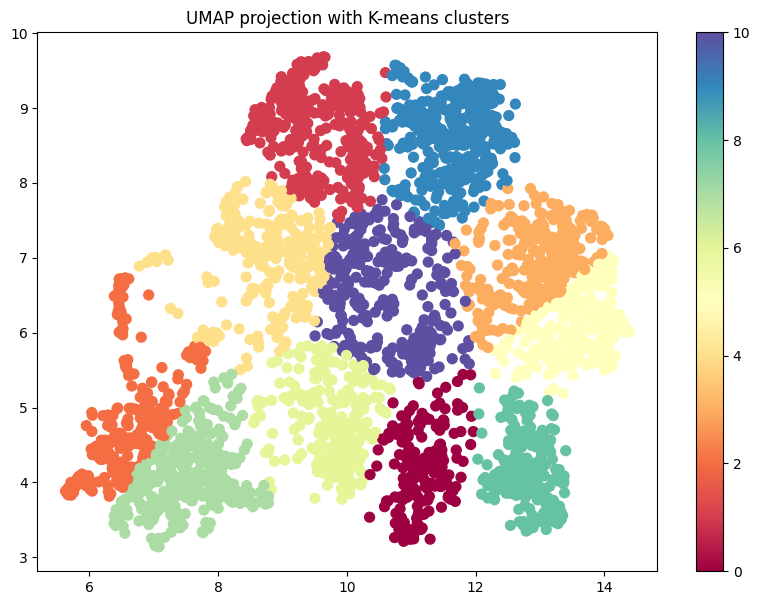

In [ ]:
topic_mapping = {
     'exercise': 1,
     'family': 2,
     'food': 3,
     'sleep': 4,
     'friends': 5,
     'health': 6,
     'recreation': 7,
     'god': 8,
     'love': 9,
     'school': 10,
     'work':11,
     'no topic': 0  # Or any other mapping you prefer
 }

goemotion_labeled['topic_numerical'] = goemotion_labeled['predicted_label'].map(topic_mapping)

# Load a suitable sentence-transformer model for embeddings
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and fast

# Apply to each cleaned text
goemotion_labeled['embeddings'] = goemotion_labeled['processed_text'].apply(lambda x: embedding_model.encode(x))

# Reduce to 2D space using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(np.stack(goemotion_labeled['embeddings'].values))

# K-means clustering on reduced embeddings
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
goemotion_labeled['cluster'] = kmeans.fit_predict(umap_embeddings)

silhouette_avg = silhouette_score(umap_embeddings, goemotion_labeled['cluster'])
db_score = davies_bouldin_score(umap_embeddings, goemotion_labeled['cluster'])
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Score: {db_score}")
no_topic_rate = sum(goemotion_labeled['predicted_label'] == 'no topic') / len(goemotion_labeled)
print(f"Percentage of 'no topic' labels: {no_topic_rate:.2%}")
# Silhouette score based on the generated labels
silhouette_score_generated_labels = silhouette_score(umap_embeddings, goemotion_labeled['predicted_label'])
print(f"Silhouette Score for Generated Labels: {silhouette_score_generated_labels}")

plt.figure(figsize=(10, 7))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=goemotion_labeled['cluster'], cmap='Spectral', s=50)
plt.colorbar()
plt.title("UMAP projection with K-means clusters")
plt.show()

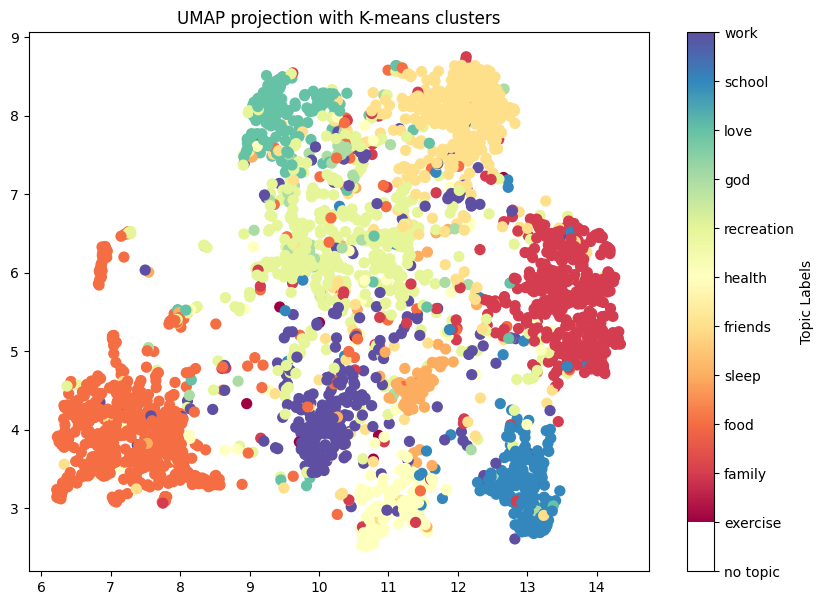

In [ ]:
# Reverse the mapping for color bar
reverse_topic_mapping = {v: k for k, v in topic_mapping.items()}

# Create a scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
                      c=goemotion_labeled['topic_numerical'], cmap='Spectral', s=50)

# Add color bar to indicate the mapping between colors and numerical labels
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(0, 12))  # Set the ticks to correspond to topic values
cbar.set_ticklabels([reverse_topic_mapping[i] for i in range(12)])  # Use labels instead of numbers
cbar.set_label('Topic Labels')  # Label for the color bar

# Title and show plot
plt.title("UMAP projection with K-means clusters")
plt.show()

In [ ]:
# Function to calculate consistency of labels within each cluster and the most common label
def cluster_label_consistency(df, cluster_col, label_col):
    cluster_consistency = {}
    cluster_most_common_label = {}

    for cluster_num in df[cluster_col].unique():
        # Get all labels in the current cluster
        cluster_labels = df[df[cluster_col] == cluster_num][label_col]

        # Find the most common label in this cluster
        most_common_label, count = Counter(cluster_labels).most_common(1)[0]

        # Calculate consistency as the percentage of texts with the most common label
        consistency = count / len(cluster_labels)

        # Store consistency and most common label for the cluster
        cluster_consistency[cluster_num] = consistency
        cluster_most_common_label[cluster_num] = most_common_label

    # Average consistency across all clusters
    avg_consistency = sum(cluster_consistency.values()) / len(cluster_consistency)

    return cluster_consistency, cluster_most_common_label, avg_consistency

# Example usage
cluster_consistency, cluster_most_common_label, avg_consistency = cluster_label_consistency(goemotion_labeled, 'cluster', 'predicted_label')

print("Cluster-wise Label Consistency:")
print(cluster_consistency)

print("\nMost Common Label in Each Cluster:")
print(cluster_most_common_label)

print(f"\nAverage Label Consistency: {avg_consistency}")

Cluster-wise Label Consistency:
{10: 0.35777126099706746, 7: 0.924119241192412, 1: 0.5631868131868132, 8: 0.9057377049180327, 3: 0.8210526315789474, 9: 0.8944723618090452, 2: 0.9623287671232876, 0: 0.728110599078341, 4: 0.7722772277227723, 6: 0.7471698113207547, 5: 0.8682170542635659}

Most Common Label in Each Cluster:
{10: 'recreation', 7: 'food', 1: 'love', 8: 'school', 3: 'family', 9: 'friends', 2: 'food', 0: 'health', 4: 'recreation', 6: 'work', 5: 'family'}

Average Label Consistency: 0.7767675884719126


## Correction

In [ ]:
import re

def correct_confusions(predicted_label, text):

    # Convert text to lowercase for case-insensitive matching
    text = text.lower()

    # Define extended keyword patterns for each label
    label_patterns = {
        'exercise': r'\b(exercise|workout|gym|sport\w*|athlet\w*|jab)\b',
        'health': r'\b(therap\w*|counsel\w*|doctor|wellness|health\w*|mental\w*|well-being|placebo|fear|illness|medicine|medical|hospital|depress\w*|anxiety|bipolar|moody)\b',
        'recreation': r'\b(play\w*|game\w*|art\w*|plant\w*|carv\w*|recreat\w*|hobby|emot\w*|burglar|cheer\w*)\b',
        'love': r'\b(boyfriend|girlfriend|partner|sex|intimacy|romance|relationship)\b',
        'family': r'\b(parents|family|son|daughter|dad|mom|brother|sister|grandparent\w*|child\w*|relative\w*|household|kin|mother|father|cousin\w*)\b',
        'work': r'\b(job|career|workplace|colleague\w*|pay|salary|profession\w*|employ\w*)\b',
        'food': r'\b(flavor\w*|cook\w*|gram\w*|eat|liquid)\b'
    }

    if predicted_label == 'work':
        applicable_labels = ['exercise', 'health', 'recreation', 'food']
    elif predicted_label == 'recreation':
        applicable_labels = ['exercise', 'health', 'work', 'love', 'food']
    elif predicted_label == 'friend':
        applicable_labels = ['food', 'work', 'recreation', 'love', 'exercise', 'health']
    elif predicted_label == 'health':
        applicable_labels = ['food', 'exercise']
    elif predicted_label == 'love':
        applicable_labels = ['exercise', 'recreation', 'family', 'food']
    elif predicted_label == 'family':
        applicable_labels = ['health']
    elif predicted_label == 'food':
        applicable_labels = ['health']
    else:
       applicable_labels = []

    # Check the text against patterns for applicable labels
    for label in applicable_labels:
        if re.search(label_patterns[label], text):
            return label

    # Default to the predicted label if no corrections match
    return predicted_label

# Apply the function to your DataFrame
goemotion_labeled['corrected_label'] = goemotion_labeled.apply(
    lambda row: correct_confusions(
        predicted_label=row['predicted_label'],
        text=row['processed_text']
    ),
    axis=1
)

# Inspect differences between original and corrected labels
goemotion_labeled[goemotion_labeled.corrected_label != goemotion_labeled.predicted_label][['text', 'predicted_label', 'corrected_label']]

,text,predicted_label,corrected_label
935,Did the burglar win? It's fine and all that he...,work,recreation
1685,Dementia is in my family so this is pretty exc...,family,health
1762,"So one partner has a higher sex drive, what sh...",recreation,love
2180,"I love your art style, that looks fantastic!",love,recreation
2900,She was carving her initials on its side with ...,work,recreation
3442,No. That’s an actually pot plant. You have to ...,work,recreation
3925,Emotes have a ridiculous amount of effort put ...,work,recreation
4435,That was a brutal shift. Honestly he should be...,work,recreation
5055,There are too many depressing headlines on the...,recreation,health
5081,i'm not that into shower sex tho. like it's fu...,recreation,love


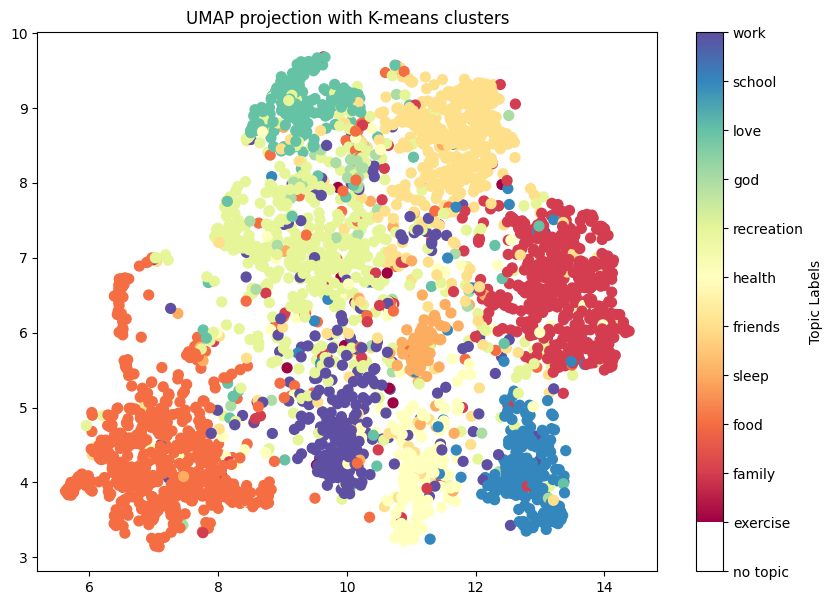

In [ ]:
topic_mapping = {
     'exercise': 1,
     'family': 2,
     'food': 3,
     'sleep': 4,
     'friends': 5,
     'health': 6,
     'recreation': 7,
     'god': 8,
     'love': 9,
     'school': 10,
     'work':11,
     'no topic': 0  # Or any other mapping you prefer
 }

goemotion_labeled['corrected_topic_numerical'] = goemotion_labeled['corrected_label'].map(topic_mapping)

# Reverse the mapping for color bar
reverse_topic_mapping = {v: k for k, v in topic_mapping.items()}

# Create a scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
                      c=goemotion_labeled['corrected_topic_numerical'], cmap='Spectral', s=50)

# Add color bar to indicate the mapping between colors and numerical labels
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(0, 12))  # Set the ticks to correspond to topic values
cbar.set_ticklabels([reverse_topic_mapping[i] for i in range(12)])  # Use labels instead of numbers
cbar.set_label('Topic Labels')  # Label for the color bar

# Title and show plot
plt.title("UMAP projection with K-means clusters")
plt.show()

In [ ]:
from collections import Counter

# Function to calculate consistency of labels within each cluster and the most common label
def cluster_label_consistency(df, cluster_col, label_col):
    cluster_consistency = {}
    cluster_most_common_label = {}

    for cluster_num in df[cluster_col].unique():
        # Get all labels in the current cluster
        cluster_labels = df[df[cluster_col] == cluster_num][label_col]

        # Find the most common label in this cluster
        most_common_label, count = Counter(cluster_labels).most_common(1)[0]

        # Calculate consistency as the percentage of texts with the most common label
        consistency = count / len(cluster_labels)

        # Store consistency and most common label for the cluster
        cluster_consistency[cluster_num] = consistency
        cluster_most_common_label[cluster_num] = most_common_label

    # Average consistency across all clusters
    avg_consistency = sum(cluster_consistency.values()) / len(cluster_consistency)

    return cluster_consistency, cluster_most_common_label, avg_consistency

# Example usage
cluster_consistency, cluster_most_common_label, avg_consistency = cluster_label_consistency(goemotion_labeled, 'cluster', 'corrected_label')

print("Cluster-wise Label Consistency:")
print(cluster_consistency)

print("\nMost Common Label in Each Cluster:")
print(cluster_most_common_label)

print(f"\nAverage Label Consistency: {avg_consistency}")

Cluster-wise Label Consistency:
{10: 0.36363636363636365, 7: 0.9186991869918699, 1: 0.5467032967032966, 8: 0.9057377049180327, 3: 0.8140350877192982, 9: 0.8944723618090452, 2: 0.9554794520547946, 0: 0.7649769585253456, 4: 0.768976897689769, 6: 0.7283018867924528, 5: 0.8527131782945736}

Most Common Label in Each Cluster:
{10: 'recreation', 7: 'food', 1: 'love', 8: 'school', 3: 'family', 9: 'friends', 2: 'food', 0: 'health', 4: 'recreation', 6: 'work', 5: 'family'}

Average Label Consistency: 0.7739756704668039


In [ ]:
goemotion_labeled[['text', 'corrected_label']].rename(columns={'corrected_label': 'topic'}).to_csv('goemotion_label.csv', index=False) # index=False prevents writing row indices

# Download the file (Google Colab specific)
from google.colab import files
files.download('goemotion_label.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Inital output without adjustment

In [ ]:
goemotion_labeled_prev = pd.read_csv("goemotion_labeled_preprocess_prev.csv")
print(goemotion_labeled_prev.shape)
print(goemotion_labeled_prev['predicted_label'].value_counts(normalize=True) * 100)
goemotion_labeled_prev = goemotion_labeled_prev[goemotion_labeled_prev["predicted_label"] != "no topic"]
print(goemotion_labeled_prev['predicted_label'].value_counts())
print(goemotion_labeled_prev.shape)

(45909, 6)
predicted_label
no topic      86.133438
work           3.988325
recreation     2.260995
food           1.877627
family         1.413666
love           1.254656
friends        1.158814
school         0.649110
health         0.607724
sleep          0.309308
god            0.296238
exercise       0.050099
Name: proportion, dtype: float64
predicted_label
work          1831
recreation    1038
food           862
family         649
love           576
friends        532
school         298
health         279
sleep          142
god            136
exercise        23
Name: count, dtype: int64
(6366, 6)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Silhouette Score: 0.4267045557498932
Davies-Bouldin Score: 0.7452240331290501
Percentage of 'no topic' labels: 0.00%
Silhouette Score for Generated Labels: 0.052937816828489304


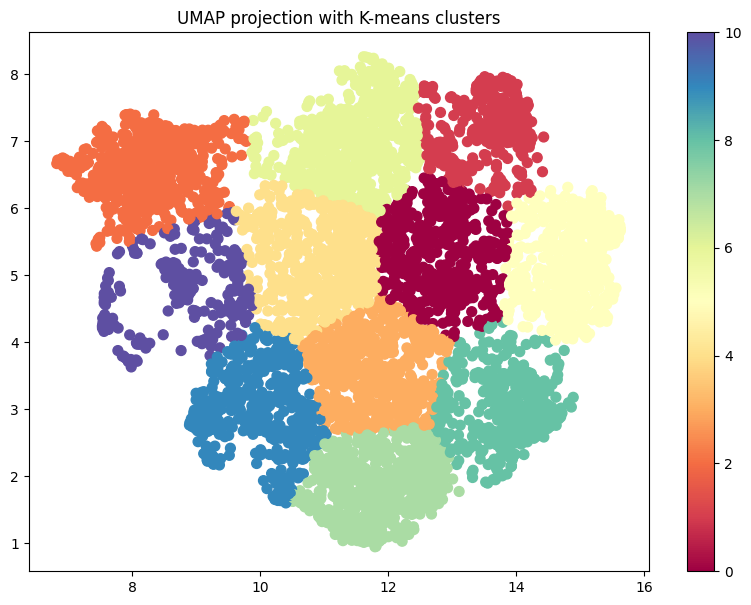

In [ ]:
topic_mapping = {
     'exercise': 1,
     'family': 2,
     'food': 3,
     'sleep': 4,
     'friends': 5,
     'health': 6,
     'recreation': 7,
     'god': 8,
     'love': 9,
     'school': 10,
     'work':11,
     'no topic': 0  # Or any other mapping you prefer
 }

goemotion_labeled_prev['topic_numerical'] = goemotion_labeled_prev['predicted_label'].map(topic_mapping)

# Load a suitable sentence-transformer model for embeddings
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and fast

# Apply to each cleaned text
goemotion_labeled_prev['embeddings'] = goemotion_labeled_prev['processed_text'].apply(lambda x: embedding_model.encode(x))

# Reduce to 2D space using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(np.stack(goemotion_labeled_prev['embeddings'].values))

# K-means clustering on reduced embeddings
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
goemotion_labeled_prev['cluster'] = kmeans.fit_predict(umap_embeddings)

silhouette_avg = silhouette_score(umap_embeddings, goemotion_labeled_prev['cluster'])
db_score = davies_bouldin_score(umap_embeddings, goemotion_labeled_prev['cluster'])
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Score: {db_score}")
no_topic_rate = sum(goemotion_labeled_prev['predicted_label'] == 'no topic') / len(goemotion_labeled_prev)
print(f"Percentage of 'no topic' labels: {no_topic_rate:.2%}")
# Silhouette score based on the generated labels
silhouette_score_generated_labels = silhouette_score(umap_embeddings, goemotion_labeled_prev['predicted_label'])
print(f"Silhouette Score for Generated Labels: {silhouette_score_generated_labels}")

plt.figure(figsize=(10, 7))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=goemotion_labeled_prev['cluster'], cmap='Spectral', s=50)
plt.colorbar()
plt.title("UMAP projection with K-means clusters")
plt.show()

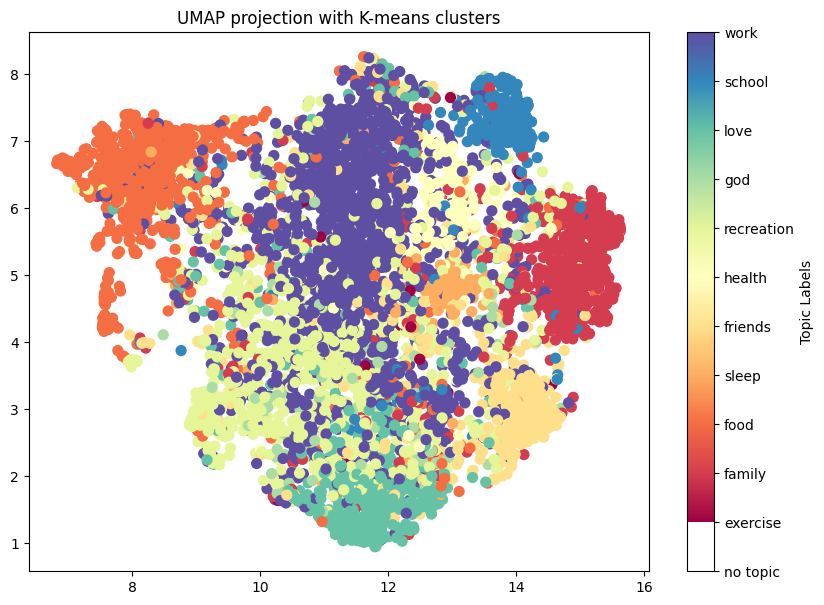

In [ ]:
# Reverse the mapping for color bar
reverse_topic_mapping = {v: k for k, v in topic_mapping.items()}

# Create a scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
                      c=goemotion_labeled_prev['topic_numerical'], cmap='Spectral', s=50)

# Add color bar to indicate the mapping between colors and numerical labels
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(0, 12))  # Set the ticks to correspond to topic values
cbar.set_ticklabels([reverse_topic_mapping[i] for i in range(12)])  # Use labels instead of numbers
cbar.set_label('Topic Labels')  # Label for the color bar

# Title and show plot
plt.title("UMAP projection with K-means clusters")
plt.show()

In [ ]:
from collections import Counter

# Function to calculate consistency of labels within each cluster and the most common label
def cluster_label_consistency(df, cluster_col, label_col):
    cluster_consistency = {}
    cluster_most_common_label = {}

    for cluster_num in df[cluster_col].unique():
        # Get all labels in the current cluster
        cluster_labels = df[df[cluster_col] == cluster_num][label_col]

        # Find the most common label in this cluster
        most_common_label, count = Counter(cluster_labels).most_common(1)[0]

        # Calculate consistency as the percentage of texts with the most common label
        consistency = count / len(cluster_labels)

        # Store consistency and most common label for the cluster
        cluster_consistency[cluster_num] = consistency
        cluster_most_common_label[cluster_num] = most_common_label

    # Average consistency across all clusters
    avg_consistency = sum(cluster_consistency.values()) / len(cluster_consistency)

    return cluster_consistency, cluster_most_common_label, avg_consistency

# Example usage
cluster_consistency, cluster_most_common_label, avg_consistency = cluster_label_consistency(goemotion_labeled_prev, 'cluster', 'predicted_label')

print("Cluster-wise Label Consistency:")
print(cluster_consistency)

print("\nMost Common Label in Each Cluster:")
print(cluster_most_common_label)

print(f"\nAverage Label Consistency: {avg_consistency}")

Cluster-wise Label Consistency:
{0: 0.30093457943925234, 4: 0.6981450252951096, 2: 0.868632707774799, 7: 0.6187766714082503, 1: 0.6004901960784313, 10: 0.375, 3: 0.3671274961597542, 8: 0.6617100371747212, 6: 0.8324022346368715, 9: 0.6127886323268206, 5: 0.84}

Most Common Label in Each Cluster:
{0: 'work', 4: 'work', 2: 'food', 7: 'love', 1: 'school', 10: 'food', 3: 'recreation', 8: 'friends', 6: 'work', 9: 'recreation', 5: 'family'}

Average Label Consistency: 0.6160006891176373


# Twitter

In [ ]:
# Hugging Face Twitter emotions dataset
# sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5)
twitter_df = pd.read_parquet("hf://datasets/dair-ai/emotion/unsplit/train-00000-of-00001.parquet")
twitter_df.head()

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


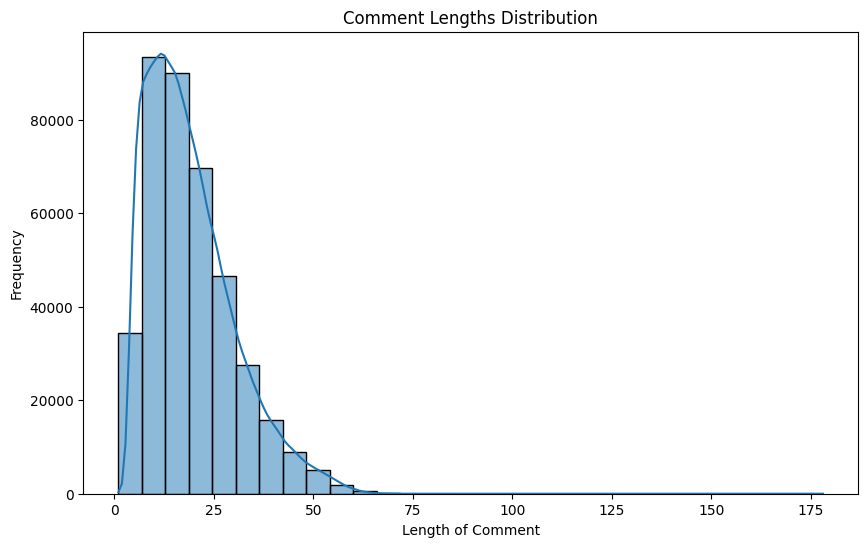

In [ ]:
twitter_df = twitter_df.drop_duplicates(subset=['text'])
plt.figure(figsize=(10, 6))
sns.histplot(twitter_df['text'].apply(lambda x: len(x.split())), bins=30, kde=True)
plt.title('Comment Lengths Distribution')
plt.xlabel('Length of Comment')
plt.ylabel('Frequency')
plt.show()

## Preprocess

In [ ]:
topics = ["family", "work", "food", "sleep", "friends", "health", "recreation", "god", "love", "school", "exercise"]

# Different thresholds for each class for twitter dataset
class_thresholds = {
    "family": 0.8,
    "work": 0.9,
    "food": 0.75,
    "sleep": 0.7,
    "friends": 0.7,
    "health": 0.8,
    "recreation": 0.9,
    "god": 0.8,
    "love": 0.75,
    "school": 0.8,
    "exercise": 0.7
}

In [ ]:
# Remove duplicated text
twitter_df = twitter_df.drop_duplicates(subset=['text'])

# Apply text dropping (you can specify lower and upper bounds or let it calculate based on IQR)
twitter_cleaned = text_drop(twitter_df, "text")
twitter_cleaned.shape

(315856, 4)

In [ ]:
# Convert to Hugging Face Dataset for GPU batch processing
twitter_cleaned = Dataset.from_pandas(twitter_cleaned)

# Apply classification in batches and add results directly to the dataset
twitter_labeled = twitter_cleaned.map(classify_topics, batched=True, batch_size=200)

# Convert back to DataFrame for analysis and save results
twitter_labeled = twitter_labeled.to_pandas()
twitter_labeled.to_csv('twitter_labeled_preprocess.csv', index=False)

print("Classification complete. Results saved to 'twitter_labeled_preprocess.csv'.")
files.download('twitter_labeled_preprocess.csv')

Map:   0%|          | 0/315856 [00:00<?, ? examples/s]

Classification complete. Results saved to 'twitter_labeled_preprocess.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluation

In [ ]:
twitter_labeled = pd.read_csv('twitter_labeled_preprocess.csv')
print(twitter_labeled.shape)
print(twitter_labeled['predicted_label'].value_counts(normalize=True) * 100)
twitter_labeled = twitter_labeled[twitter_labeled["predicted_label"] != "no topic"]
print(twitter_labeled['predicted_label'].value_counts())
twitter_labeled = twitter_labeled.dropna(subset=['predicted_label'])
print(twitter_labeled.shape)

(47433, 7)
predicted_label
no topic      92.235200
friends        1.551695
food           1.089981
love           1.009867
family         0.955051
work           0.868612
sleep          0.735790
school         0.708383
health         0.322567
exercise       0.227694
god            0.181312
recreation     0.113847
Name: proportion, dtype: float64
predicted_label
friends       736
food          517
love          479
family        453
work          412
sleep         349
school        336
health        153
exercise      108
god            86
recreation     54
Name: count, dtype: int64
(3684, 7)


In [ ]:
topic_mapping = {
     'exercise': 1,
     'family': 2,
     'food': 3,
     'sleep': 4,
     'friends': 5,
     'health': 6,
     'recreation': 7,
     'god': 8,
     'love': 9,
     'school': 10,
     'work':11,
     'no topic': 0  # Or any other mapping you prefer
 }

twitter_labeled['topic_numerical'] = twitter_labeled['predicted_label'].map(topic_mapping)

# Function to calculate consistency of labels within each cluster and the most common label
def cluster_label_consistency(df, cluster_col, label_col):
    cluster_consistency = {}
    cluster_most_common_label = {}

    for cluster_num in df[cluster_col].unique():
        # Get all labels in the current cluster
        cluster_labels = df[df[cluster_col] == cluster_num][label_col]

        # Find the most common label in this cluster
        most_common_label, count = Counter(cluster_labels).most_common(1)[0]

        # Calculate consistency as the percentage of texts with the most common label
        consistency = count / len(cluster_labels)

        # Store consistency and most common label for the cluster
        cluster_consistency[cluster_num] = consistency
        cluster_most_common_label[cluster_num] = most_common_label

    # Average consistency across all clusters
    avg_consistency = sum(cluster_consistency.values()) / len(cluster_consistency)

    return cluster_consistency, cluster_most_common_label, avg_consistency

# Example usage
cluster_consistency, cluster_most_common_label, avg_consistency = cluster_label_consistency(twitter_labeled, 'cluster', 'predicted_label')

print("Cluster-wise Label Consistency:")
print(cluster_consistency)

print("\nMost Common Label in Each Cluster:")
print(cluster_most_common_label)

print(f"\nAverage Label Consistency: {avg_consistency}")

Cluster-wise Label Consistency:
{7: 0.8184281842818428, 9: 0.8740157480314961, 1: 0.8837209302325582, 0: 0.8961748633879781, 8: 0.44, 6: 0.968421052631579, 4: 0.953125, 2: 0.9013452914798207, 3: 0.4371584699453552, 5: 0.8936781609195402, 10: 0.2671232876712329}

Most Common Label in Each Cluster:
{7: 'work', 9: 'friends', 1: 'family', 0: 'sleep', 8: 'god', 6: 'food', 4: 'friends', 2: 'love', 3: 'exercise', 5: 'school', 10: 'love'}

Average Label Consistency: 0.7575628171437638


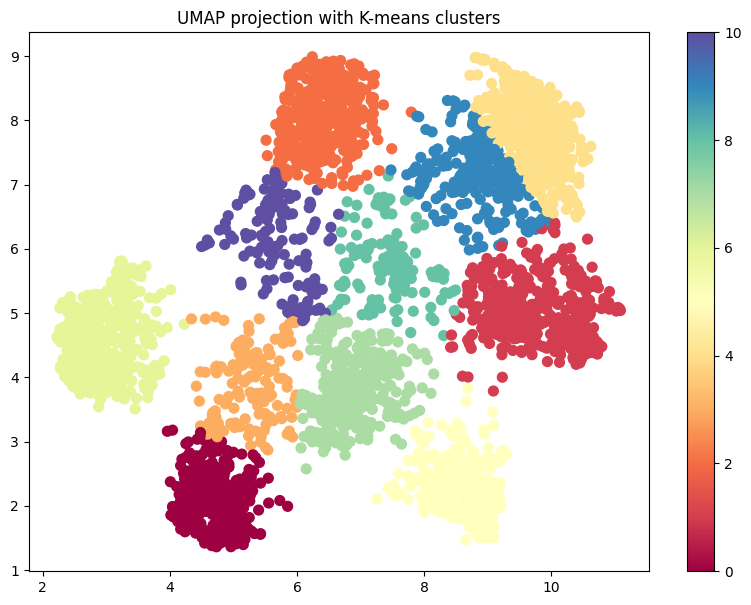

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=twitter_labeled['cluster'], cmap='Spectral', s=50)
plt.colorbar()
plt.title("UMAP projection with K-means clusters")
plt.show()

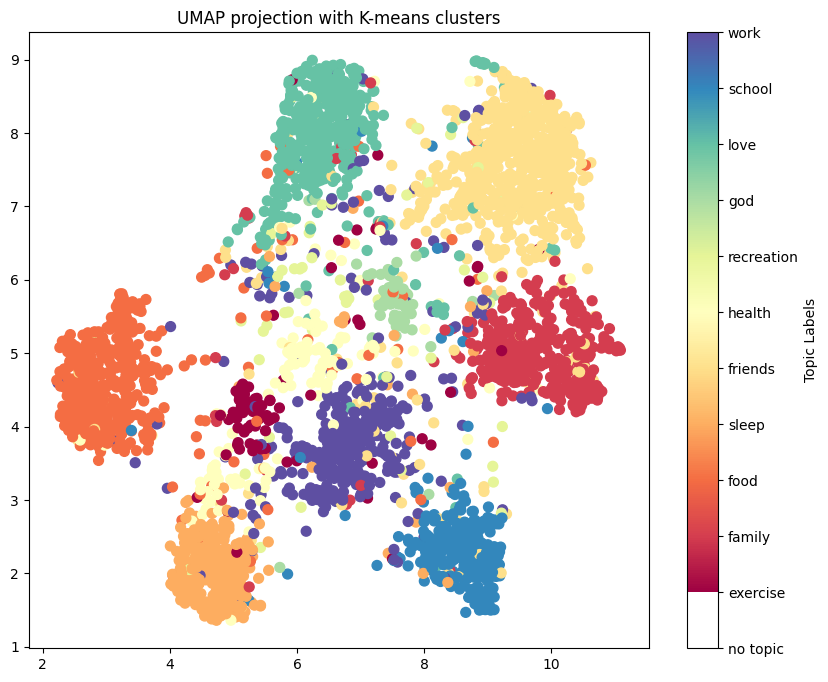

In [ ]:
# Reverse the mapping for color bar
reverse_topic_mapping = {v: k for k, v in topic_mapping.items()}

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
                      c=twitter_labeled['topic_numerical'], cmap='Spectral', s=50)

# Add color bar to indicate the mapping between colors and numerical labels
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(0, 12))  # Set the ticks to correspond to topic values
cbar.set_ticklabels([reverse_topic_mapping[i] for i in range(12)])  # Use labels instead of numbers
cbar.set_label('Topic Labels')  # Label for the color bar

# Title and show plot
plt.title("UMAP projection with K-means clusters")
plt.show()

In [ ]:
twitter_labeled[['text', 'predicted_label']].rename(columns={'predicted_label': 'topic'}).to_csv('twitter_label.csv', index=False) # index=False prevents writing row indices

# Download the file (Google Colab specific)
from google.colab import files
files.download('twitter_label.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Tuning thresholds on subset

In [ ]:
from collections import Counter

# Function to calculate consistency of labels within each cluster
def cluster_label_consistency(df, cluster_col, label_col):
    cluster_consistency = {}

    for cluster_num in df[cluster_col].unique():
        # Get all labels in the current cluster
        cluster_labels = df[df[cluster_col] == cluster_num][label_col]

        # Find the most common label in this cluster
        most_common_label, count = Counter(cluster_labels).most_common(1)[0]

        # Calculate consistency as the percentage of texts with the most common label
        consistency = count / len(cluster_labels)

        cluster_consistency[cluster_num] = consistency

    # Average consistency across all clusters
    avg_consistency = sum(cluster_consistency.values()) / len(cluster_consistency)

    return cluster_consistency, avg_consistency

# Example usage
cluster_consistency, avg_consistency = cluster_label_consistency(twitter_labeled, 'cluster', 'predicted_label')
print("Cluster-wise Label Consistency:")
print(cluster_consistency)
print(f"Average Label Consistency: {avg_consistency}")

Cluster-wise Label Consistency:
{0: 0.8536782538399353, 5: 0.8916418896597291, 3: 0.899737302977233, 2: 0.4094292803970223, 1: 0.9699876237623762, 9: 0.9615198451113263, 6: 0.909016393442623, 8: 0.501628664495114, 7: 0.8848566308243727, 10: 0.3190348525469169, 4: 0.46173688736027513}
Average Label Consistency: 0.7329334204015385


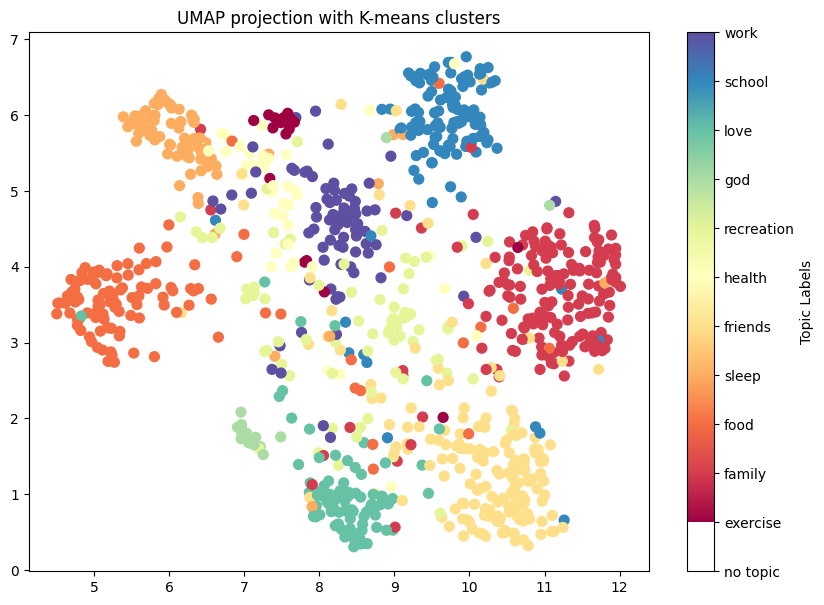

In [ ]:
# Reverse the mapping for color bar
reverse_topic_mapping = {v: k for k, v in topic_mapping.items()}

# Create a scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
                      c=twitter_labeled['topic_numerical'], cmap='Spectral', s=50)

# Add color bar to indicate the mapping between colors and numerical labels
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(0, 12))  # Set the ticks to correspond to topic values
cbar.set_ticklabels([reverse_topic_mapping[i] for i in range(12)])  # Use labels instead of numbers
cbar.set_label('Topic Labels')  # Label for the color bar

# Title and show plot
plt.title("UMAP projection with K-means clusters")
plt.show()